### generate figures and label images for HIOS TDS manuscript

### fig3
* load results from pickle file generated by "diffraction peak position_V2diffraction peak position_V2.ipynb"

Package versions:<br>
python==3.10.8<br>
numpy==1.23.5<br>
matplotlib==3.6.2<br>
ipywidgets==8.0.4<br>
pickleshare==0.7.5

In [1]:
%matplotlib widget

In [2]:
# load packages
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
data_folder = r'..\data\Figure 2_3_S1\230101205338_20kV_hexz0_camz-10_posi_003_good'

In [4]:
with open(data_folder + r'\20230518_121720scan_data_bin2_centered_crop-imgNx200diff_peak_posV2.pkl', 'rb') as f:
    data = pickle.load(f)
for i in list(data.keys()):
    exec(i + '= ' + '(data[i])')

In [5]:
data.keys()

dict_keys(['data_folder', 'data_name', 'data_path', 'img_Nx', 'img_Ny', 'scan_Nx', 'scan_Ny', 'scan_N', 'num_img', 'binning_factor', 'calibration_factor_no_binning', 'calibration_factor', 'gaussf0_val', 'gaussf1_val', 'substract_val', 'num_points', 'pos', 'pos_int'])

In [6]:
(gaussf0_val, gaussf1_val, substract_val)

(1.0, 10.0, 2.0)

In [7]:
#convert tuples to lists
if type(pos) == tuple:
    print('were tuples')
    pos = list(pos)
    pos_int = list(pos_int)

In [8]:
%%time
# get position of the diffraction peak with largest intensity for each scan point
scan_ym, scan_xm = np.mgrid[0:scan_Ny, 0:scan_Nx]
scan_points = np.hstack([scan_ym.reshape(scan_N,1), scan_xm.reshape(scan_N,1)])
scan_points_found = np.zeros((scan_N))

pos_strongest_peak_argmax = [None] * scan_N # index of the peak with the largest intensity for every scan point
pos_strongest_peak = [None] * scan_N # coordinates of the peak with the largest intensity for every scan point
index_peaks_found = [] # scan index of the diffraction pattern with more than 0 found diffraction peaks
for it in range(scan_N):
    if pos_int[it].size > 0:
        index_peaks_found.append(it)
        argmax = np.argmax(pos_int[it])
        pos_strongest_peak_argmax[it] = argmax
        pos_strongest_peak[it] = pos[it][argmax,:]
        #pos_strongest_peak_array = np.append(pos_strongest_peak_array, pos[it][argmax,:].reshape(1,2), axis = 0)
        scan_points_found[it] = pos[it].shape[0]

CPU times: total: 46.9 ms
Wall time: 46 ms


In [9]:
%%time
# convert found peaks into polar coordinates (r in pixel, phi in degree)
pos_polar = pos.copy()
for it in index_peaks_found:
    pos_polar[it] = pos_polar[it] - pos_strongest_peak[it]
    x,y = pos_polar[it][:,1], pos_polar[it][:,0] 
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x) * 180/np.pi
    pos_polar0 = np.column_stack((r,phi))
    pos_polar[it] = pos_polar0

CPU times: total: 203 ms
Wall time: 205 ms


In [10]:
%%time
MoS2_lattice_a = 0.316 # nm
d_spacing = np.sqrt(4/3)/MoS2_lattice_a # np.sqrt(4/3) for hexagonal lattice
d_spacing_delta = 0.05
r_min = (1 - d_spacing_delta)*d_spacing
r_max = (1 + d_spacing_delta)*d_spacing
angle_modulo = 60.0 # deg

pos_polar1 = pos_polar.copy()
angle_mean = [None]*scan_N
angle_std = [None]*scan_N

for it in index_peaks_found:
    r_scaled = pos_polar1[it][:,0]*calibration_factor
    ind = np.where((r_scaled > r_min) & (r_scaled < r_max))
    angles = pos_polar1[it][:,1][ind] % angle_modulo
    angle_mean[it] = np.mean(angles)
    angle_std[it] = np.std(angles)

C:\ProgramData\Miniconda3\envs\base0\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\envs\base0\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\base0\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Miniconda3\envs\base0\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Miniconda3\envs\base0\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: total: 422 ms
Wall time: 436 ms


In [11]:
r_min

3.471409846393319

In [12]:
r_max

3.8368214091715633

In [13]:
angles_mean_array = np.asarray(angle_mean, dtype = float).reshape((scan_Ny, scan_Nx)) # 
angles_mean_array[angles_mean_array == None] = np.nan

angles_std_array = np.asarray(angle_std, dtype = float).reshape((scan_Ny, scan_Nx))
angles_std_array[angles_std_array == None] = np.nan

scan_points_found_array = np.asarray(scan_points_found, dtype = float).reshape((scan_Ny, scan_Nx))

In [14]:
figsize_w = 15/2.54
#fontsize = 12
dpi = 640

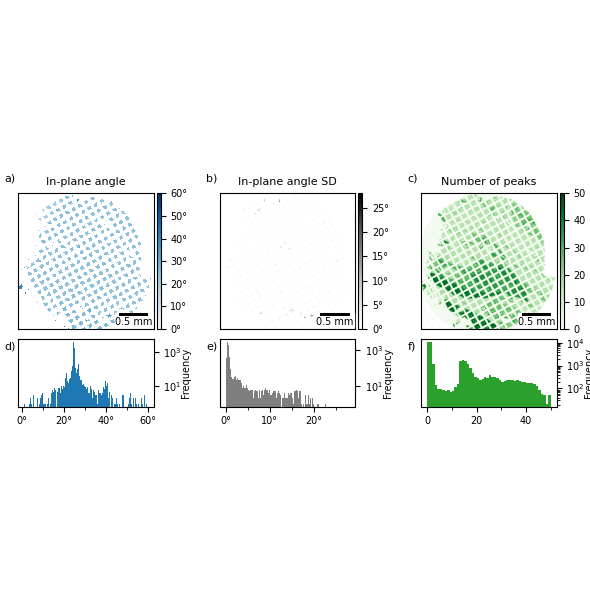

In [15]:
#generate plots for manuscript
colorbar_pad = 0.03
fs00 = 7
fs0 = 7
fs1 = 8
scalebar_fs = fs00


bottom_axes_pad = 0.1
bottom_axes_size = '50%'
suplots_blank_size = 0.2
suplots_blank_size_right = 0.1

bins0 = 300
bins1 = 300
bins2 = np.max(num_points).astype(int)

#sem_pixel_size	3.01501E-06
#iocard_scan_XStepWidth	4
scale_real = 3.01501 * 4 /1000.#mm

param1 = {'textcoords': 'axes fraction', 'horizontalalignment': 'left', 'verticalalignment':'top', 'fontsize': fs1,
          'bbox':dict(boxstyle="square,pad=0.0", fc="w", ec="w", lw=2)} #axes points
param2 = {'horizontalalignment': 'left', 'verticalalignment':'top', 'fontsize': fs1,
          'bbox':dict(boxstyle="square,pad=0.0", fc="w", ec="w", lw=2)} #axes points
xy_pos = (-0.1,1.15)
#xy_pos = (0.02,0.98)
#xy_pos1 = (0.02,0.96)
xy_pos1 = (-0.1,0.96)
#dx = 0.08
dx = 0.0


fig, ax = plt.subplots(1,6, figsize = (figsize_w,6), gridspec_kw={'height_ratios': [1], 'width_ratios': [1,suplots_blank_size, 1,suplots_blank_size, 1, suplots_blank_size_right]}, constrained_layout=True)# 
#fig, ax = plt.subplots(2,3, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1, 1]}, constrained_layout=True) 

format_angle = "%1.d°"

im0 = ax[0].imshow(np.rot90(angles_mean_array, k = 3), cmap='Blues', vmin = 0, vmax = 60) # data_proc0
ax[0].get_xaxis().set_ticks([]) #ax[0].axis('off')
ax[0].get_yaxis().set_ticks([])
divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="3%", pad = colorbar_pad) #
cbar1 = plt.colorbar(im0, cax = cax0, format = format_angle)
cbar1.ax.tick_params(labelsize=fs0)
bax0 = divider.append_axes("bottom", bottom_axes_size, pad=bottom_axes_pad) #, sharex=axScatter
bax0.hist(angles_mean_array.flatten().flatten(), bins=bins0, histtype = 'bar', color = matplotlib.colors.TABLEAU_COLORS['tab:blue']) # color = 'b' color = 'Blue'
bax0.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter(format_angle))
bax0.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
bax0.yaxis.tick_right()
bax0.set_ylabel('Frequency', size = fs0, labelpad = -0.3)
bax0.yaxis.set_label_position("right")
bax0.tick_params(labelsize=fs0)
bax0.set_yscale("log")
ax[0].set_title('In-plane angle', fontsize = fs1)
ax[0].annotate('a)', xy = (0,0), xytext = (xy_pos[0], xy_pos[1]), **param1)
#bax0.annotate('d)', xy = (0,0), xytext = (xy_pos1[0], xy_pos1[1]), **param2)
bax0.text(x = xy_pos1[0], y = xy_pos1[1], s =  'd)', transform = bax0.transAxes, **param2)
bax0.set_yscale("log")
scalebar0 = ScaleBar(scale_real, 'mm', location = 'lower right', fixed_value = 0.5, pad = 0.0,sep = 1, border_pad = 0.1, frameon=True, length_fraction=0.25, width_fraction = 0.02,font_properties = {'size': scalebar_fs}) # 1 pixel = 0.2 meter
ax[0].add_artist(scalebar0)


im1 = ax[2].imshow(np.rot90(angles_std_array, k=3),cmap='Greys') #,  vmin = 0, vmax = 30,cmap = 'gray'
ax[2].get_xaxis().set_ticks([]) #ax[1].axis('off')
ax[2].get_yaxis().set_ticks([])
divider = make_axes_locatable(ax[2])
cax1 = divider.append_axes("right", size="3%", pad = colorbar_pad)
cbar2 = plt.colorbar(im1, cax = cax1, format = format_angle)
cbar2.ax.tick_params(labelsize=fs0)
bax1 = divider.append_axes("bottom", bottom_axes_size, pad=bottom_axes_pad) #, sharex=axScatter
bax1.hist(angles_std_array.flatten(), bins=bins1, histtype = 'bar', color = matplotlib.colors.TABLEAU_COLORS['tab:gray']) # color = 'Grey'
bax1.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter(format_angle))
bax1.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
bax1.yaxis.tick_right()
bax1.set_ylabel('Frequency', size = fs0, labelpad = -0.3)
bax1.yaxis.set_label_position("right")
bax1.tick_params(labelsize=fs0)
bax1.set_yscale("log")
ax[2].set_title('In-plane angle SD', fontsize = fs1)
ax[2].annotate('b)', xy = (0,0), xytext = (xy_pos[0], xy_pos[1]), **param1)
#bax1.annotate('e)', xy = (0,0), xytext = (xy_pos1[0], xy_pos1[1]), **param2)
bax1.text(x = xy_pos1[0]+dx, y = xy_pos1[1], s =  'e)', transform = bax1.transAxes, **param2)
bax1.set_yscale("log")
scalebar2 = ScaleBar(scale_real, 'mm', location = 'lower right', fixed_value = 0.5,pad = 0.0,sep = 1, border_pad = 0.1, frameon=True, length_fraction=0.25, width_fraction = 0.02,font_properties = {'size': scalebar_fs}) # 1 pixel = 0.2 meter
ax[2].add_artist(scalebar2)

# create colormap where value 0 is white
colormap0 = matplotlib.cm.get_cmap('Greens', 256)
colormap1 = colormap0(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
colormap1[:1, :] = white
newcmp = matplotlib.colors.ListedColormap(colormap1)

im2 = ax[4].imshow(np.rot90(scan_points_found_array, k = 3), cmap = newcmp)
ax[4].get_xaxis().set_ticks([]) #ax[2].axis('off')
ax[4].get_yaxis().set_ticks([])
divider = make_axes_locatable(ax[4])
cax2 = divider.append_axes("right", size="3%", pad = colorbar_pad)
cbar3 = plt.colorbar(im2, cax = cax2)
cbar3.ax.tick_params(labelsize=fs0)
#plt.colorbar(im2, cax = ax[0,5])
bax2 = divider.append_axes("bottom", bottom_axes_size, pad=bottom_axes_pad) #, sharex=axScatter
bax2.hist(scan_points_found_array.flatten(), bins=bins2, histtype = 'bar', color = matplotlib.colors.TABLEAU_COLORS['tab:green']) #  color = 'Green'
bax2.yaxis.tick_right()
bax2.set_ylabel('Frequency', size = fs0, labelpad = -0.3)
bax2.yaxis.set_label_position("right")
bax2.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
bax2.tick_params(labelsize=fs0)
ax[4].set_title('Number of peaks', fontsize = fs1)
ax[4].annotate('c)', xy = (0,0), xytext = (xy_pos[0], xy_pos[1]), **param1)
#bax2.text(0.5, 0.5,'hi',transform=bax2.transAxes)
bax2.text(x = xy_pos1[0]+dx, y = xy_pos1[1], s =  'f)', transform = bax2.transAxes, **param2)
bax2.set_yscale("log")
scalebar4 = ScaleBar(scale_real, 'mm', location = 'lower right', fixed_value = 0.5, pad = 0.0,sep = 1, border_pad = 0.1, frameon=True, length_fraction=0.25, width_fraction = 0.02,font_properties = {'size': scalebar_fs}) # 1 pixel = 0.2 meter
ax[4].add_artist(scalebar4)

ax[1].axis('off')
ax[1].set_aspect(1.0)
ax[3].axis('off')
ax[3].set_aspect(1.0)
ax[5].axis('off')
ax[5].set_aspect(1.0)

plt.show()

In [16]:
date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig('fig3_' + date_str + '.png',dpi = dpi,bbox_inches = "tight")